# Machine Learning for Business and Analytics
Materials - Dataset: Titanic

**Content Materials**

1. EDA, Data Preprocessing and Feature Engineering
2. Interpretable Machine Learning
    - Regression-based Interpretation
    - Decision Tree Plot
    - Decision Boundary of SVC and k-Means
    - Dendogram of Hierarchical Clustering
3. Explainable Machine Learning
    - Partial Dependence
    - Feature Importance
    - Shapley Value of Explanation (SHAP)
    - Local Interpretable Model-agnostic Explanation (LIME)

## Import used Libraries

In [1]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.preprocessing import LabelEncoder

import string
import warnings
warnings.filterwarnings('ignore')

## Read Data

In [2]:
df = pd.read_csv("titanic_data.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## EDA, Preprocessing and Feature Engineering

In data preprocessing and feature engineering, we would like to ensure there is no problem per feature, so we gonna check every feature that we have one by one.

**0. Missing Values Detection**

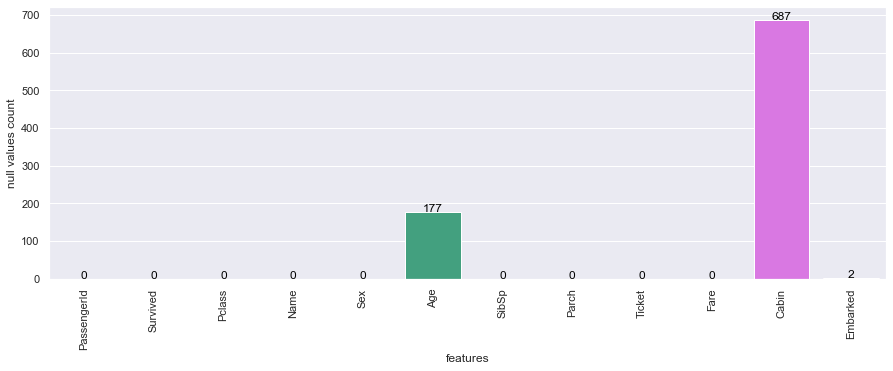

In [3]:
null_df = df.isnull().sum().reset_index()
plt.figure(figsize=(15,5))
ax = sns.barplot(null_df["index"], null_df[0], palette="husl")
ax.set(xlabel="features", ylabel="null values count")
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
ax.set_ylim(0)
[ax.text(index,value[1],value[1], color='black', ha="center") for index,value in enumerate(null_df.values)]
plt.show()

There are missing values on feature Age, Cabin, and Embarked. However, we won't directly remove those features since we are going to handle those missing values in each feature. 

**1. Age**

In [4]:
df['Age'].nunique()

88

In [5]:
print(f"Unique Value of feature Age is: {df['Age'].nunique()}")
df["Age"].describe()

Unique Value of feature Age is: 88


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Since `Age` feature has relatively high gap between max and min value and high standard deviation (1/2 of its average), so its better to transform into categorical (age group). First of all, we should fill the null values with median based on `Sex` and `Pclass` to shape better pattern of data.

In [6]:
# Missing value handling
df["Age"] = df.groupby(["Sex", "Pclass"])["Age"].apply(lambda x: x.fillna(x.median()))
# Create age group by 10 groups
df["Age"] = pd.qcut(df["Age"], 10)
df["Age"].head()

0    (20.0, 22.0]
1    (34.0, 40.0]
2    (25.0, 26.0]
3    (34.0, 40.0]
4    (34.0, 40.0]
Name: Age, dtype: category
Categories (10, interval[float64]): [(0.419, 16.0] < (16.0, 20.0] < (20.0, 22.0] < (22.0, 25.0] ... (30.0, 34.0] < (34.0, 40.0] < (40.0, 47.0] < (47.0, 80.0]]

In [7]:
# Age group distribution by passenger id
df.groupby(["Age"])["PassengerId"].count()

Age
(0.419, 16.0]    100
(16.0, 20.0]      79
(20.0, 22.0]      94
(22.0, 25.0]     164
(25.0, 26.0]      18
(26.0, 30.0]     101
(30.0, 34.0]      69
(34.0, 40.0]     116
(40.0, 47.0]      61
(47.0, 80.0]      89
Name: PassengerId, dtype: int64

**2. Embarked**

In [8]:
# Lets see the value distribution
df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [9]:
# Filling the missing values in Embarked with S, as its mode (appears most frequent)
df["Embarked"] = df["Embarked"].fillna("S")
df["Embarked"].head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

**3. Fare**

In [10]:
print(f"Unique Value of feature Age is: {df['Age'].nunique()}")
df["Fare"].describe()

Unique Value of feature Age is: 10


count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

The situation is similar with `Age` feature, where standard deviation > mean, while unique value is only 10. In such way, its better to transform this feature into categorical data (fare-group). We are going to make a `Fare` group into 10 groups.

In [11]:
df["Fare"] = pd.qcut(df["Fare"], 10)
df["Fare"].head()

0      (-0.001, 7.55]
1    (39.688, 77.958]
2       (7.854, 8.05]
3    (39.688, 77.958]
4       (7.854, 8.05]
Name: Fare, dtype: category
Categories (10, interval[float64]): [(-0.001, 7.55] < (7.55, 7.854] < (7.854, 8.05] < (8.05, 10.5] ... (21.679, 27.0] < (27.0, 39.688] < (39.688, 77.958] < (77.958, 512.329]]

**4. Family Size**

- `SibSp`: Number of Siblings/Spouses Aboard
- `Parch`: Number of Parents/Children Aboard

We are going to make new feature: `Family Size` which consist of `SibSp`, `Parch`, and its passenger. Then, we create new feature `Family Size Group` based on family size number, while remove the numerical feature afterwards.

In [12]:
df["Family_Size"] = df["SibSp"] + df["Parch"] + 1
family_map = {1: "Alone", 2: "Small", 3: "Small", 4: "Small", 5: "Medium", 6: "Medium", 7: "Large", 8: "Large", 11: "Large"}
df["Family_Size_Grouped"] = df["Family_Size"].map(family_map)
df["Family_Size_Grouped"].head()

df.drop(["Family_Size"], inplace=True, axis=1)
df["Family_Size_Grouped"].head()

0    Small
1    Small
2    Alone
3    Small
4    Alone
Name: Family_Size_Grouped, dtype: object

**5. Cabin**

`Cabin` has most missing value in the dataset, however we are going to create new feature: named `Deck`. This feature describes the group name if deck position based on the first alphabetic letter in `Cabin` value, let say `C85` means `C` for `Deck`. The missing `Cabin` will be replaced by `M` which stands for `missing`

In [13]:
# Missing value into "M" deck~ missing deck
df["Deck"] = df["Cabin"].apply(lambda s: s[0] if pd.notnull(s) else "M")
# Replace value "T" into "A"
idx = df[df["Deck"] == "T"].index
df.loc[idx, "Deck"] = "A"
# Create three group replacement of A-G
df["Deck"] = df["Deck"].replace(["A", "B", "C"], "ABC")
df["Deck"] = df["Deck"].replace(["D", "E"], "DE")
df["Deck"] = df["Deck"].replace(["F", "G"], "FG")
# Remove Cabin since its unused
df.drop(["Cabin"], inplace=True, axis=1)

df["Deck"].head()

0      M
1    ABC
2      M
3    ABC
4      M
Name: Deck, dtype: object

**6. Ticket and PClass**

In [14]:
df["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
347088      6
3101295     6
           ..
364512      1
236171      1
315151      1
113773      1
250652      1
Name: Ticket, Length: 681, dtype: int64

Feature `Ticket` has many unique values (681), so we will transform this into `Ticket Frequency` based on its appearance of each ticket. 

In [15]:
df["Ticket_Frequency"] = df.groupby("Ticket")["Ticket"].transform("count")
df.drop(["Ticket"], inplace=True, axis=1)

df["Pclass"] = df["Pclass"].astype("str")

df["Ticket_Frequency"].head()

0    1
1    1
2    1
3    2
4    1
Name: Ticket_Frequency, dtype: int64

**7. Name**

We try to extract the name, by its title and marriage status, we create `Title` and `Is Married` as new features

In [16]:
df["Title"] = df["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
df["Is_Married"] = "no"
df["Is_Married"].loc[df["Title"] == "Mrs"] = "yes"

df.drop(["Name"], inplace=True, axis=1)

df[["Title","Is_Married"]].head()

,Title,Is_Married
0,Mr,no
1,Mrs,yes
2,Miss,no
3,Mrs,yes
4,Mr,no


**Final Cleanup**

In [17]:
# Since this feature is no longer be used, now we remove this
df.drop(["PassengerId"], inplace=True, axis=1)

**Check Recent Data**

In [18]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_Size_Grouped,Deck,Ticket_Frequency,Title,Is_Married
0,0,3,male,"(20.0, 22.0]",1,0,"(-0.001, 7.55]",S,Small,M,1,Mr,no
1,1,1,female,"(34.0, 40.0]",1,0,"(39.688, 77.958]",C,Small,ABC,1,Mrs,yes
2,1,3,female,"(25.0, 26.0]",0,0,"(7.854, 8.05]",S,Alone,M,1,Miss,no
3,1,1,female,"(34.0, 40.0]",1,0,"(39.688, 77.958]",S,Small,ABC,2,Mrs,yes
4,0,3,male,"(34.0, 40.0]",0,0,"(7.854, 8.05]",S,Alone,M,1,Mr,no


**Check Data Cardinality**

Data with high cardinality will slow down the process of machine learning if we transform into dummy variables, in such way, we would like to transform data with high cardinality into ordinal-based data.

In [19]:
for x in df.columns:
    total_unique_values = len(df[x].unique())
    print(f"Unique value of {x} is {total_unique_values}")

Unique value of Survived is 2
Unique value of Pclass is 3
Unique value of Sex is 2
Unique value of Age is 10
Unique value of SibSp is 7
Unique value of Parch is 7
Unique value of Fare is 10
Unique value of Embarked is 3
Unique value of Family_Size_Grouped is 4
Unique value of Deck is 4
Unique value of Ticket_Frequency is 7
Unique value of Title is 17
Unique value of Is_Married is 2


Feature `Age`, `Fare` and `Title` has so many unique values (>10). Since `Age` and `Fare` are numerical feature, where 0 > 1, so we transform into ordinal-based data type, while we let `Title` feature working as usual

In [20]:
high_cardinality_data = ["Fare","Age"]

for feature in high_cardinality_data:        
    df[feature] = LabelEncoder().fit_transform(df[feature])

df_encoded = pd.get_dummies(df)
df_encoded.head()

,Survived,Age,SibSp,Parch,Fare,Ticket_Frequency,Pclass_1,Pclass_2,Pclass_3,Sex_female,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess,Is_Married_no,Is_Married_yes
0,0,2,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,1,7,1,0,8,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
2,1,4,0,0,2,1,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
3,1,7,1,0,8,2,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
4,0,7,0,0,2,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0


## Modeling Stage

Now lets move to the main dish, we are not giving too much focus on hyperparameter/model selection since our objective is creating interpretable AI and explainable AI, so let use the normal stages of machine learning building. 

**a. Set X and Y features**

In [21]:
# Separate between X and y features
X = df_encoded.drop(["Survived"],axis=1)
y = df_encoded["Survived"].values
# Store the column names
feature_names = X.columns
target_names = "Survived"

**b. PCA to transform 2D Vectors**

In [22]:
from sklearn.decomposition import PCA

# We create PCA to transform all of X features into 2D vectors
# PCA will be used on plotting 2D contour
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ["PC1","PC2"])

**c. Train Test Split**

In [23]:
from sklearn.model_selection import train_test_split

# Ratio 70 : 30
# Normal Dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123)

# Principal Component Dataset
X_train_pc, X_test_pc, y_train_pc, y_test_pc = train_test_split(principalDf,y,test_size=0.3,random_state=123)

**Don't forget to import these:**

In [24]:
import plotly.express as px
import plotly.graph_objects as go

### Interpretable ML  
**Regression Based Intepretation**

In [28]:
# import statsmodels.api as sm

# X_sm = sm.add_constant(X)

# clf_logit = sm.Logit(y, X_sm)

# odds_ratio = [round(x,2) for x in np.exp(clf_logit.fit().params.values)]

# print(odds_ratio[:5])
# print(clf_logit.fit().summary())

***
$\mathbf{\text{Logistic Regression Explanation}}$<br>
***
1.&emsp;Logistic Regression Formula: 
$$P = \frac{e^{\alpha+\beta X}}{1+e^{\alpha+\beta X}}$$

2.&emsp;We have 40 features of X, lets take 3 of them: `Intercept` = -41.7286, `Age` = -0.0891, `SibSp` = -0.2282, `Parch` = -0.0169, then:

$$P = \frac{e^{-41.7286 -0.0891 X_{Age} -0.2282 X_{SibSp} -0.0169 X_{Parch} + ... + \beta X}}{1+e^{-41.7286 -0.0891 X_{Age} -0.2282 X_{SibSp} -0.0169 X_{Parch} + ... + \beta X}}$$

3.&emsp;One of the way to interpret the cofficients is using odds ratio score for each feature, lets take `Fare` whose odds ratio score is 1.05. It means, when `Fare` is increasing (1 group) then the probability to survive is increasing by 5%.

**Decision Tree Plot**

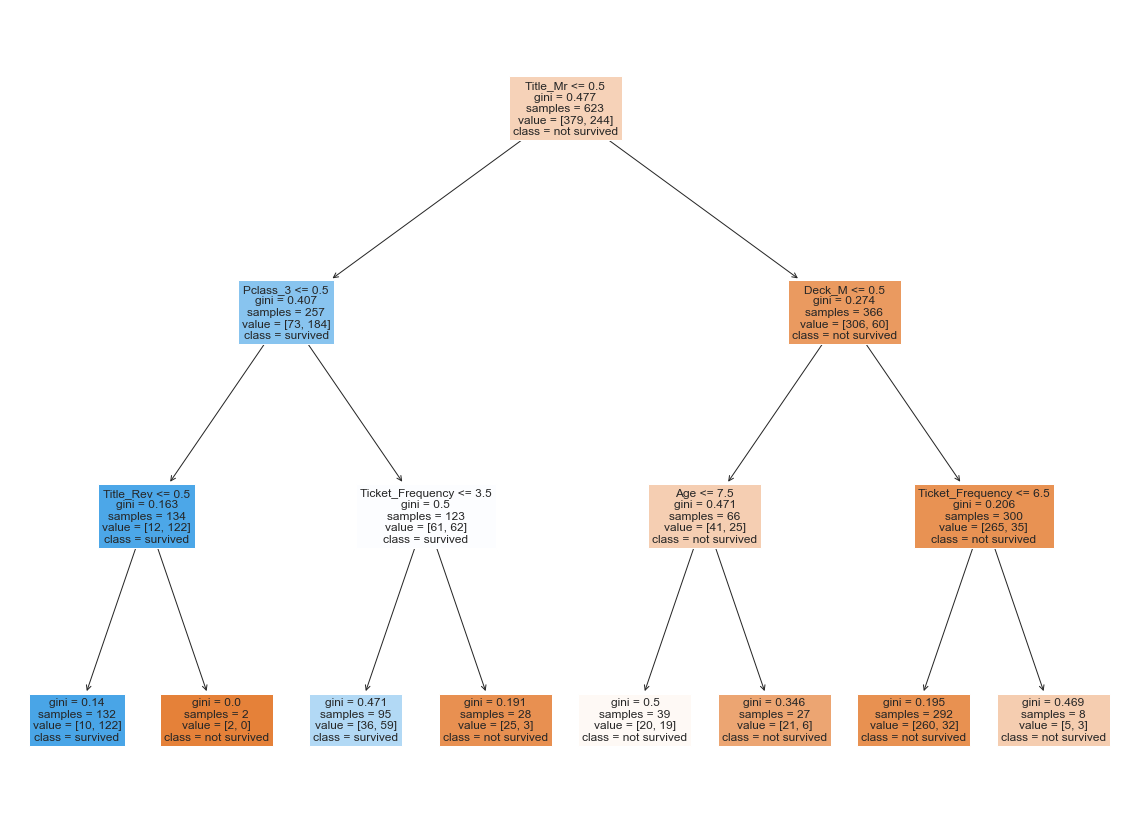

In [35]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

tree= DecisionTreeClassifier(max_depth=3)
tree.fit(X_train,y_train)
y_pred= tree.predict(X_test)

# create tree

plt.figure(figsize=(20,15))
plot_tree(tree,
         feature_names=feature_names,
         class_names=['not survived', 'survived'],
         filled=True)

# plt.savefig('decision_tree.png')
plt.show()

Dengan menunjukkan pohon keputusan, kita bisa dengan mudah menjelaskan bagaimana desicion tree mengambil keputusan melalui serangkaian algoritma IF ELSE THEN

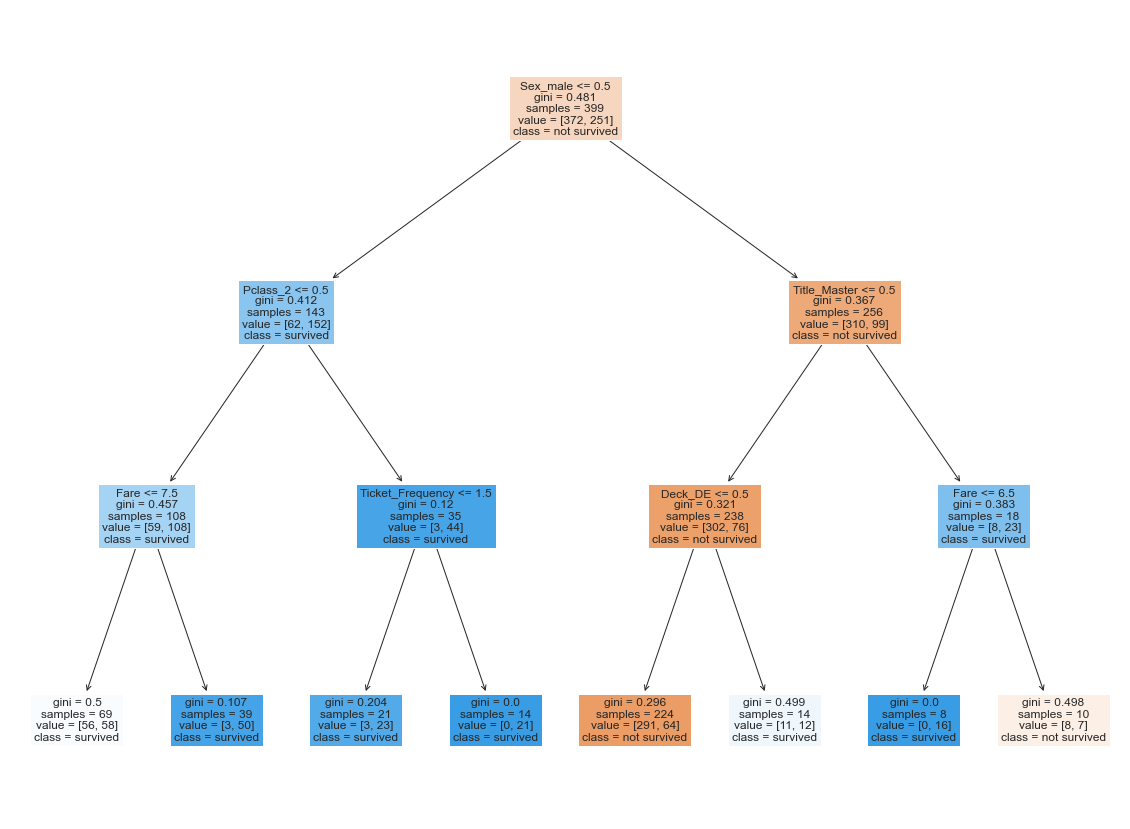

In [38]:
from sklearn.ensemble import RandomForestClassifier


rf= RandomForestClassifier(max_depth=3)
rf.fit(X_train,y_train)
y_pred= rf.predict(X_test)

# create tree

plt.figure(figsize=(20,15))
plot_tree(rf.estimators_[1], #ambil pohon pertama yg dibuat rf
         feature_names=feature_names,
         class_names=['not survived', 'survived'],
         filled=True)

# plt.savefig('random forest.png')
plt.show()

bisa juga digunakan untuk tree based ensemble, tapi kurang disarankan, karena keputusan model ensembel tidak didasarkan dari salah satu pohonnya saja.

**Desicion Boundary**  
Menunjukkan batas antar kelas hasil klasifiaksi model pada plot 2/3 dimensi.
Karena feature/dimensi yang bisa digunakan untuk visualisasi hanya 2/3 dimensi, maka, sebaiknya visualisasi menggunakan hasil PCA

In [40]:
# Please do not touch, code to generate decision boundary
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

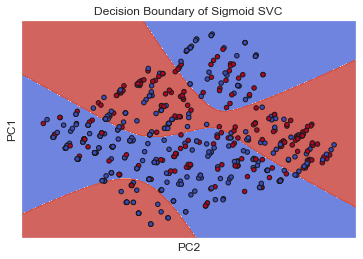

In [43]:
from sklearn.svm import SVC

np.random.seed(123)
# Create the model and train it using principal component features
model = SVC(kernel="sigmoid")
clf = model.fit(X_train_pc, y_train_pc)

# Set-up grid for plotting.
fig, ax = plt.subplots()
X0, X1 = X_train_pc.iloc[:, 0], X_train_pc.iloc[:, 1]
xx, yy = make_meshgrid(X0, X1)
# Create the plot
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y_train_pc, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel("PC1")
ax.set_xlabel("PC2")
ax.set_xticks(())
ax.set_yticks(())
ax.set_title("Decision Boundary of Sigmoid SVC")
plt.show()

Warna pada batasan/background menunjukkan hasil prediksi, sementara warna pada masing-masing titik data menunjukkan y-True, di mana warna biru= not survived, warna merah=survived. Dari plot decision boundary di atas, kita bisa meilhat seberapa baik hasil prediksi model kita.

**Dendogram Clustering**  
Biasa digunakan untuk menunjukkan hasil hierarchical clustering.

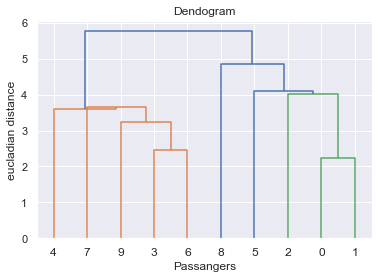

In [44]:
import scipy.cluster.hierarchy as sch
np.random.seed(123)

dendogram= sch.dendrogram(sch.linkage(X_train.iloc[:10], method='centroid'))
plt.title('Dendogram')

plt.xlabel('Passangers')
plt.ylabel('eucladian distance')
plt.show()

### Explainable AI  
Model yang akan coba kita jelaskan adalah xgboost

In [45]:
# base model
from xgboost import XGBClassifier

np.random.seed(123)
xgb= XGBClassifier()
xgb.fit(X_train,y_train)

y_pred_xgb= xgb.predict(X_test)
y_pred_proba_xgb= xgb.predict_proba(X_test)

[09:42:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


**Partial Dependence Plot**  
Partial Dependence plot (PD) menunjukkan hubungan antara sebagian kecil data input terhadap hasil prediksi dari model. PD menunjukkan bagaimana hasil prediksi bergantung sebagian pada nilai variabel tertentu yang diinput. Misal, PD plot bisa menunjukkan apakah kemungkinan keselamatan penumpang meningkat secara linear dibandingkan dengan umur (age).

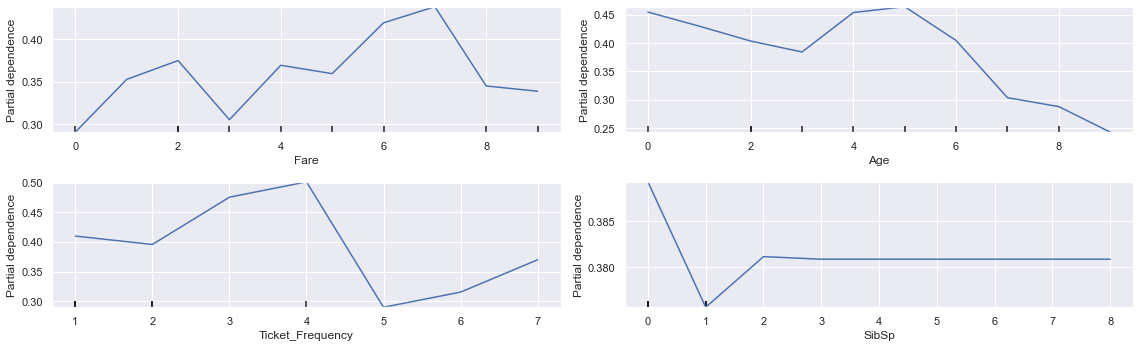

In [47]:
from sklearn.inspection import plot_partial_dependence

fig,ax= plt.subplots(2,2, figsize=(16,5))

plot_partial_dependence(xgb, X_train,['Fare'], ax=ax[0,0])
plot_partial_dependence(xgb, X_train,['Age'], ax=ax[0,1])
plot_partial_dependence(xgb, X_train,['Ticket_Frequency'], ax=ax[1,0])
plot_partial_dependence(xgb, X_train,['SibSp'], ax=ax[1,1])
plt.tight_layout()


***
$\mathbf{\text{Cara Baca}}$<br>
***
* axis y menunjukkan probability penumpang untuk selamat (kelas 1)
* axis x menunjukkan nilai dari feature yang dipilih

***
$\mathbf{\text{Insight}}$<br>
***

1. **Fare**  
Semakin tinggi ongkos perjalanan (fare) yang dibayar penumpang, semakin tinggi juga kemungkinan penumpang tersebut untuk selamat. Ini masuk akal, karena, semakin mahal penumpang membayar, maka seharusnya fasilitas yang penumpang dapatkan juga semakin baik, termasuk priviledge untuk dievakuasi terlebih dahulu ketika kecelakaan terjadi.


2. **Age**
Semakin muda umur penumpang, semakin besar kemungkinan untuk selamat, karena, penumpang muda kemungkinan akan dievakuasi terlebih dahulu dibandingkan yang tua. 



3. .....


**Feature Importance Plot**  
Feature importance merupakan teknik untuk memberi nilai pada suatu feature input yang mengindikasikan seberapa penting feature tersebut ketika model membuat prediksi.

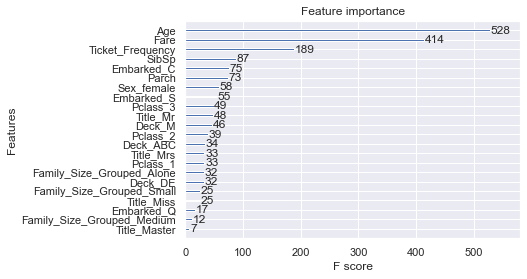

In [49]:
from xgboost import plot_importance

plot_importance(xgb)
plt.show()

***
$\mathbf{\text{Cara Baca}}$<br>
***
* axis y menunjukkan nama feature
* axis x menunjukkan seberapa sering feature tersebut digunakan sebagai splitter, semakin sering, semakinin tinggi kontribusi feature tersebut dalam penentuan selamat/tidaknya penumpang

***
$\mathbf{\text{Insight}}$<br>

1. Fitur peling penting: 
`Age`,`Fare`, `Ticket_Frequency` dan `SibSp` memiliki kontribusi terbesar pada model untuk memutuskan selamat/tidaknya seorang penumpang

2. Fitur-fitur yang mengindikasikan gender wanita (sex_female, title_mrs, title_miss) memiliki kontribusi umum yang lebih tinggi dibanding fitur-fitur yang mengindikasikan gender pria (title_mr, sex_male, dst). Ini menunjukkan bahwa gender wanita didahulukan saat evakuasi dibandingkan pria.

**Shapley Value of Explanations (SHAP)**  
SHAP menggunakan pendekatan *game theory* untuk menjelaskan output dari suatu model machine learning. 

In [52]:
# !pip install shap

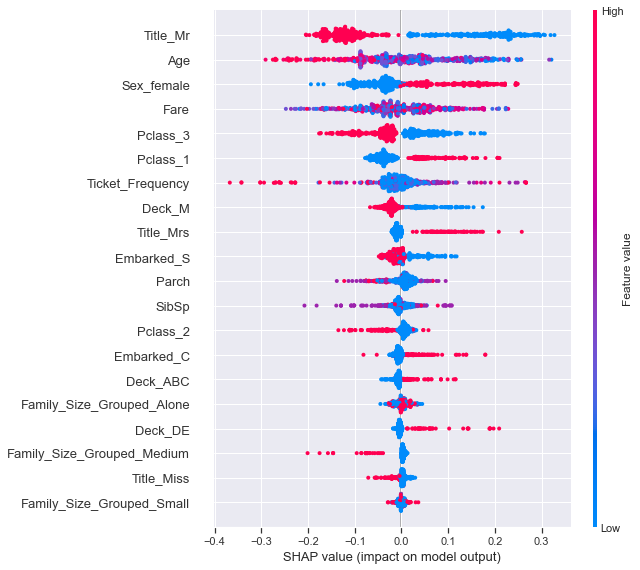

In [53]:
import shap

shap_value= shap.TreeExplainer(xgb, # tree based model, tidak bisa dipakai untuk gradient boosting
                              data=X_train,
                              feature_dependence='independent',
                              model_output='probability').shap_values(X_train)
shap.summary_plot(shap_value,X_train, feature_names=feature_names)

In [65]:
# shap_value= shap.explainers.Tree(xgb, # tree based model, tidak bisa dipakai untuk gradient boosting
#                               data=X_train)
# shap.plots.beeswarm(shap_value(X_train),max_display=15)

***
$\mathbf{\text{Cara Baca}}$<br>
***
* Y axis: Feature
* X axis: nilai SHAP/kontribusi feature tertentu terhadap hasil prediksi model berdasarkan nilainya.
    * nilai tinggi pada suatu feature ditandai denga warna merahm untuk nilai yang rendah ditandai dengan warna biru
    * plot pada bagian kiri dari bagan, menunjukkan dukungan terhadap kelas 0 (nont survive), plot pada bagian kanan menunjukkan dukungan pada kelas 1 (survive) 
    
Contoh:
* Pada feature sex_female, hanya ada 2 nilai, yaitu 1 (female, warna merah), dan 0 (bukan female, warna biru). Pada bagan, kita bisa lihat, bahwa titik merah pada feature sex_female berada di bagian kanan bagan, ini menunjukkan jika nilai sex_female= 1, maka kemungkinan penumpang tersebut untuk selamat lebih tinggi dibandingkan penumpang yang nilai sex_female=0

Side note:
* seberapa kuat nilai SHAP menunjukkan seberapa besar impact dari feature tersebut terhadap keputusan model, artinya, feature `Title_mr` memiliki impact yang jauh lebih tinggi dibandingkan `title_miss` terhdap keputusan model.

**SHAP per Observation**

In [67]:
shap.initjs() #start javascript, must have

In [68]:
def shap_plot(j, model, S): #j posisi index data, model: model yang dipakai, S, data train
    explainerModel= shap.TreeExplainer(model)
    shap_values_model= explainerModel.shap_values(S)
    p=shap.force_plot(explainerModel.expected_value, shap_values_model[j],S.iloc[[j]])
    return p

In [70]:
X_test.iloc[[0,1,6]] # observasi yang ingin kita lihat hasilnya

,Age,SibSp,Parch,Fare,Ticket_Frequency,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess,Is_Married_no,Is_Married_yes
172,0,1,1,4,3,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
524,3,0,0,0,1,0,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0
161,7,0,0,5,1,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1


In [72]:
y_test[[0,1,6]] #target

array([1, 0, 1], dtype=int64)

In [73]:
print(f'nilai actual untuk data ini adalah {("survived" if y_test[0]==1 else "not survived")}')

shap_plot(0,xgb,X_test)

nilai actual untuk data ini adalah survived


nilai feature untuk observasi di atas adalah:
* family size grouped alone=0
* sex female =1
* parch=1
* sipsp =1
* age =0
* title mr= 0
* pclass_3=1  

Singkatnya, penumpang ini adalah penumpang wanita usia muda yang duduk di pclass 3 dan memiliki keluarga berukuran kecil.  

`output value` dari penumpang ini bernilai positif (1.06), menunjukkan bahwa hasil prediksi untuk penumpang ini adalah `Survived`, sesuai dengan data aktual.  

Fitur-fitur berwarna merah (sex_female=1, title Mr=0, sibsp=1, dst) berkontribusi terhadap kemungkinan penumpang ini selamat, sementara fitu-fitur berwarna biru( pclass=3, dst) berkontribusi terhadap kemungkinan penumpang tidak selamat.  

Jadi kita bisa menjelaskan bahwa, penumpang 0 selamat karena dia wanita berusia muda yang tidaks sendirian.

In [74]:
# bandingkan dengan data berikut
print(f'nilai actual untuk data ini adalah {("survived" if y_test[1]==1 else "not survived")}')

shap_plot(1,xgb,X_test)

nilai actual untuk data ini adalah not survived


Penumpang 1 adalah pria usia tengah baya yang duduk di pclass 3 dengan hasil prediksi tidak selamat(output value negatif, -3.02) (sesuai dengan data aktual).

Fitur-fitur yang berkontribusi pada ketidakselamatan penumpang 1 adalah, gender pria, usia yang sudah tidak muda, dan posisi penumpang di pclass 3.

**Local Intepretable Model-Agnostic Explanation (LIME)**  
Lime adalah teknik explainable baru yang menjelaskan hasil prediksi dengan mempelajari model intepretabel lokal dari hasil prediksi


In [76]:
# !pip install lime

In [77]:
import lime
from lime import lime_tabular

In [79]:
# pakai random forest
rf=RandomForestClassifier(random_state=123)
rf.fit(X_train,y_train)
score=rf.score(X_test,y_test)

In [81]:
# explainer
explainer= lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['note survived','survived'],
    mode='classification'

)

**Explain Features**

nilai actual untuk data ini adalah survived


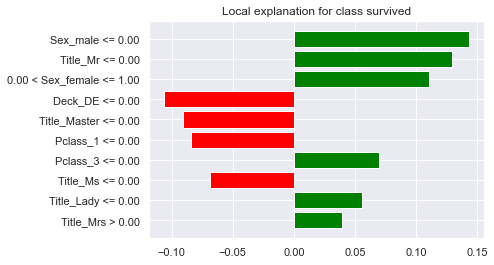

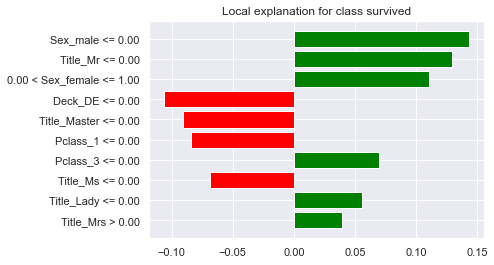

In [85]:
#mari kita lihat hasil dari data observasi 6

print(f'nilai actual untuk data ini adalah {("survived" if y_test[6]==1 else "not survived")}')

exp=explainer.explain_instance(X_test.iloc[6],
                              rf.predict_proba,
                              num_features=10)
exp.as_pyplot_figure()

***
$\mathbf{\text{Cara Baca}}$<br>
***
* Y axis: Feature
* X axis: kontribusi feature untuk prediksi ke kelas 1. Kalau nilai negatif, maka feture tersebut 'mendukung' kelas 0.

$\mathbf{\text{Insight}}$<br>
1. feature: sex_male<=0, title_mr<=0, sex_female<=1, menunjukkan bahwa gender (wanita) memiliki kontribusi yang cukup besar agar penumpang diprediksi selamat.

2. ....

**Feature Based on Show in Notebook**

In [88]:
print(f'nilai actual untuk data ini adalah {("survived" if y_test[1]==1 else "not survived")}')


exp = explainer.explain_instance(
    data_row=X_test.iloc[1], 
    predict_fn=rf.predict_proba
)

exp.show_in_notebook(show_table=True)

nilai actual untuk data ini adalah not survived


***
$\mathbf{\text{Cara Baca}}$<br>
***
* Y axis: Feature
* X axis: kontribusi feature untuk prediksi ke kelas 1. Kalau nilai negatif, maka kemungkinan untuk survive menurun
Warna antara biru dan orange juga menunjukkan apakah suatu fitur mendukung kelas 1(orange) atau kelas 0 (biru)